In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer,
)

from category_encoders import LeaveOneOutEncoder

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In this assignment, you will work more independently. Perform the following steps:
    
1. Select which columns are best suited to predict whether the rating is above 4.5
2. Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)
3. Create a random forest model and evaluate
4. Using grid search cross validation, tweak the parameters to produce a better performing model
5. Show and discuss your results

Good luck!

### Data Cleaning

In [3]:
reviews = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv"
)

reviews = reviews.dropna()
reviews = reviews.drop(columns=["Current Ver", "Android Ver", "App", "Genres"])

<IPython.core.display.Javascript object>

In [4]:
# Remove dollar signs and convert price to numeric
reviews["Price"] = reviews["Price"].str.strip("$")
reviews["Price"] = pd.to_numeric(reviews["Price"])

<IPython.core.display.Javascript object>

In [5]:
# Dropping high price apps
# (out of scope if project's interest is in typical app behavior)
reviews = reviews[reviews["Price"] < 10]

<IPython.core.display.Javascript object>

In [6]:
# Convert reviews to numeric
reviews["Reviews"] = pd.to_numeric(reviews["Reviews"])

<IPython.core.display.Javascript object>

In [7]:
# Convet Type to bool
reviews["is_free"] = reviews["Type"] == "Free"
reviews["is_free"] = reviews["is_free"].astype(int)
reviews = reviews.drop(columns="Type")

<IPython.core.display.Javascript object>

In [8]:
# Convert content rating to numeric
reviews = reviews[~reviews["Content Rating"].isin(["Adults only 18+", "Unrated"])]
content_rating_map = {"Everyone": 0, "Everyone 10+": 1, "Teen": 2, "Mature 17+": 3}
reviews["Content Rating"] = reviews["Content Rating"].replace(content_rating_map)

<IPython.core.display.Javascript object>

In [9]:
# Size has values like: "18M", "201k", and "Varies with device"
# 17% of data has 'Varies with device'
# (reviews["Size"] == "Varies with device").mean()

# Instead of dropping these rows and converting to numeric
# Going to drop column
reviews = reviews.drop(columns="Size")

<IPython.core.display.Javascript object>

In [10]:
# Converting last updated date into days since last update
reviews["Last Updated"] = pd.to_datetime(reviews["Last Updated"])
reviews["days_since_last_update"] = (
    pd.to_datetime("today") - reviews["Last Updated"]
).dt.days

reviews = reviews.drop(columns="Last Updated")

<IPython.core.display.Javascript object>

In [11]:
# Going to convert installs to numeric
reviews["Installs"] = reviews["Installs"].str.replace("[,+]", "")
reviews["Installs"] = pd.to_numeric(reviews["Installs"])

<IPython.core.display.Javascript object>

In [12]:
reviews.head()

,Category,Rating,Reviews,Installs,Price,Content Rating,is_free,days_since_last_update
0,ART_AND_DESIGN,4.1,159,10000,0.0,0,1,971
1,ART_AND_DESIGN,3.9,967,500000,0.0,0,1,963
2,ART_AND_DESIGN,4.7,87510,5000000,0.0,0,1,765
3,ART_AND_DESIGN,4.5,215644,50000000,0.0,2,1,819
4,ART_AND_DESIGN,4.3,967,100000,0.0,0,1,807


<IPython.core.display.Javascript object>

In [13]:
reviews.dtypes

Category                   object
Rating                    float64
Reviews                     int64
Installs                    int64
Price                     float64
Content Rating              int64
is_free                     int64
days_since_last_update      int64
dtype: object

<IPython.core.display.Javascript object>

### Prep data for model

In [14]:
cat_cols = ["Category"]
num_cols = [
    "Reviews",
    "Installs",
    "Price",
    "Content Rating",
    "is_free",
    "days_since_last_update",
]

<IPython.core.display.Javascript object>

In [15]:
X = reviews.drop(columns="Rating")
y = reviews["Rating"]

<IPython.core.display.Javascript object>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [17]:
encoder = LeaveOneOutEncoder(cols=cat_cols)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

/usr/local/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<IPython.core.display.Javascript object>

In [18]:
grid = {"max_depth": [4, 8, 10, 12], "n_estimators": [100, 150, 200]}

model = GridSearchCV(RandomForestRegressor(), grid, cv=2, verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   17.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

<IPython.core.display.Javascript object>

In [19]:
model.best_params_

{'max_depth': 10, 'n_estimators': 150}

<IPython.core.display.Javascript object>

In [20]:
model.score(X_train, y_train)

0.4336510272597821

<IPython.core.display.Javascript object>

In [21]:
model.score(X_test, y_test)

0.13568412469669677

<IPython.core.display.Javascript object>

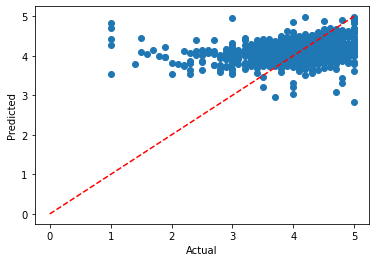

<IPython.core.display.Javascript object>

In [22]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot([0, 5], [0, 5], "--", c="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [23]:
resid = y_pred - y_test

<IPython.core.display.Javascript object>

In [24]:
# MAE: On average, we're within 0.33 of the correct rating
np.mean(np.abs(resid))

0.32813296224063104

<IPython.core.display.Javascript object>

In [25]:
# MAPE: On average, we're within 10% of the right answer
np.mean(np.abs(resid / y_test))

0.09654521384355427

<IPython.core.display.Javascript object>

We're overfit, and essentially guessing the average rating.  The ratings are so similar across all the app types/stats that its hard to distinguish these small differences.  Even with our model not performing well in terms of $R^2$ we are still performing well on metrics like MAE and MAPE.  We're performing poorly on $R^2$ because our model doesn't add much value over just guessing the mean rating as a prediction (which would also have fairly low MAE and MAPE).

In [26]:
# if we guessed mean
y_pred = y_train.mean()
resid = y_pred - y_test

mae = np.mean(np.abs(resid))
mape = np.mean(np.abs(resid / y_test))

print(mae)
print(mape)

0.36690482333607594
0.10724238933176479


<IPython.core.display.Javascript object>

In [27]:
# Most important features are:
#   * How many reviews?
#   * How long since last update?
#   * How many installs?
#   * What category?
importance_df = pd.DataFrame(
    {"feat": X_train.columns, "importance": model.best_estimator_.feature_importances_}
)

importance_df = importance_df.sort_values("importance", ascending=False)
importance_df

,feat,importance
1,Reviews,0.368165
6,days_since_last_update,0.241665
2,Installs,0.170971
0,Category,0.154981
3,Price,0.039315
4,Content Rating,0.019807
5,is_free,0.005096


<IPython.core.display.Javascript object>